In [1]:
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import ctypes
libgcc_s = ctypes.CDLL('libgcc_s.so.1')
import torch
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/avic/OOD_Orientation_Generalization')
from my_dataclasses import *
from train.dataset import *
from train.train import *

In [3]:
e = ExpData.get_experiments(3)

In [4]:
batch_size = 1000
rd = RotationDataset(e)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
dataset = rd._Dataset(rd, df)
dataloader = DataLoader(dataset, batch_size, num_workers=4, shuffle=False, pin_memory=True)

In [5]:
checkpoint = torch.load(e.checkpoint)
model = models.resnet18(pretrained=False, num_classes=50)
model.load_state_dict(checkpoint)
model.cuda()
pass

In [6]:
assert len(dataset) % batch_size == 0
activations = np.zeros((len(dataloader) * batch_size, 512))

w = model.fc.weight.cpu().detach().numpy()

global avgpool_output
def hook(model, input, output):
    global avgpool_output
    avgpool_output = torch.squeeze(output).cpu().detach().numpy()

In [7]:
model.avgpool.register_forward_hook(hook)
model.eval()
for b, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    images, targets = map(lambda t: t.to(device='cuda', non_blocking=True), batch)
    with torch.no_grad():
        preds = model(images)
    activations[batch_size * b : batch_size * (b + 1)] = avgpool_output
np.save(e.activations_heatmap, activations)

100%|██████████| 250/250 [07:24<00:00,  1.78s/it]


In [5]:
activations = np.load(e.activations_heatmap)

In [6]:
heatmap = np.zeros((20, 20, 20))

In [7]:
def get_heatmap_cell_ranges(num_cubelets):

    assert num_cubelets % 2 == 0
    
    longtitude = num_cubelets + 1
    latitude = num_cubelets // 2
    r = 1

    dim0, delta_theta = np.linspace(-np.pi, np.pi, longtitude, retstep=True)
    delta_S = delta_theta / latitude

    dim1 = 1-np.arange(2*latitude+1) * delta_S / (r**2 * delta_theta)
    dim1 =  np.arccos(dim1)
    dim1 = (dim1 - (np.pi / 2))

    dim2 = np.linspace(-np.pi, np.pi, num_cubelets + 1)

    
    return dim0, dim1, dim2

def div_heatmap(df, activations, num_cubelets=20):
    dim0s, dim1s, dim2s = get_heatmap_cell_ranges(num_cubelets)

    df['object_x_cat'] = pd.cut(df.object_x, dim0s).cat.codes
    df['object_y_cat'] = pd.cut(df.object_y, dim1s).cat.codes
    df['object_z_cat'] = pd.cut(df.object_z, dim2s).cat.codes
    df['model_cats'] = pd.Categorical(df.model_name, categories=df.model_name.unique(), ordered=True).codes

    groups = df.groupby([df.model_cats, df.object_x_cat, df.object_y_cat, df.object_z_cat])
    groups_count = groups.ngroups
    
    activations_heatmap = np.zeros((512, 50, num_cubelets, num_cubelets, num_cubelets))
    for i, group in tqdm(enumerate(groups), total=groups_count):
        m, x, y, z = group[0][0], group[0][1], group[0][2], group[0][3]
        activations_heatmap[:, m, x, y, z] = np.mean(activations[group[1].index.tolist()], axis=0)

    return activations_heatmap

In [ ]:
activations_heatmaps = div_heatmap(dataset.frame, activations)

100%|██████████| 185705/185705 [00:11<00:00, 16774.02it/s]


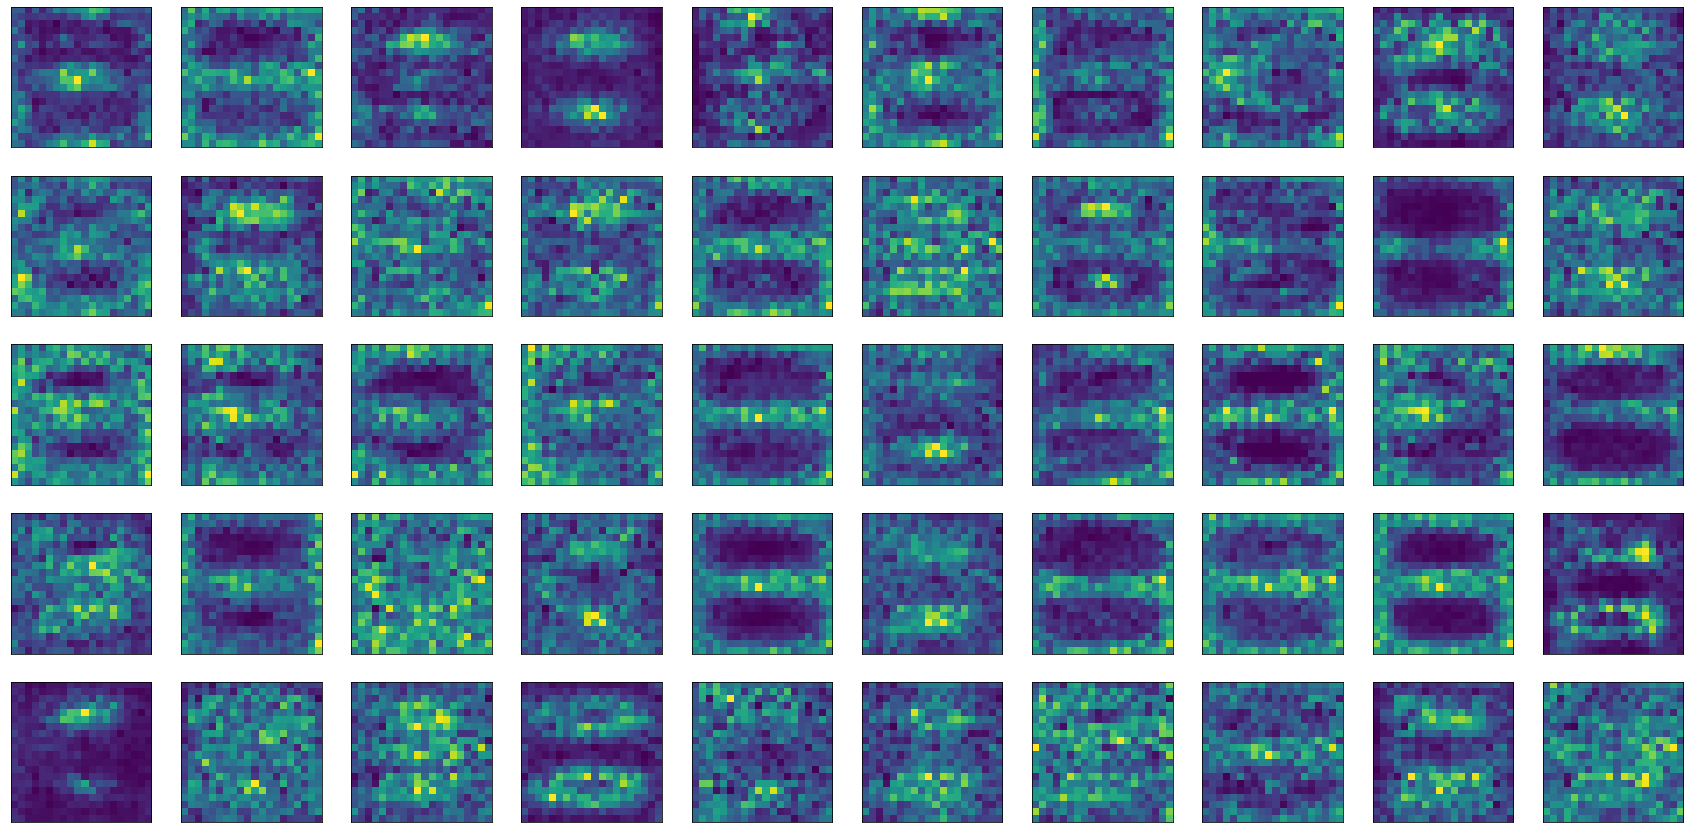

In [16]:
plt.close('all')
_, axes = plt.subplots(5, 10, figsize=(30, 15))
for x in range(5):
    for y in range(10):
        axes[x][y].imshow(np.mean(activations_heatmaps[(x * 10) + y, 45], axis=2))
        axes[x][y].set_xticks([])
        axes[x][y].set_yticks([])

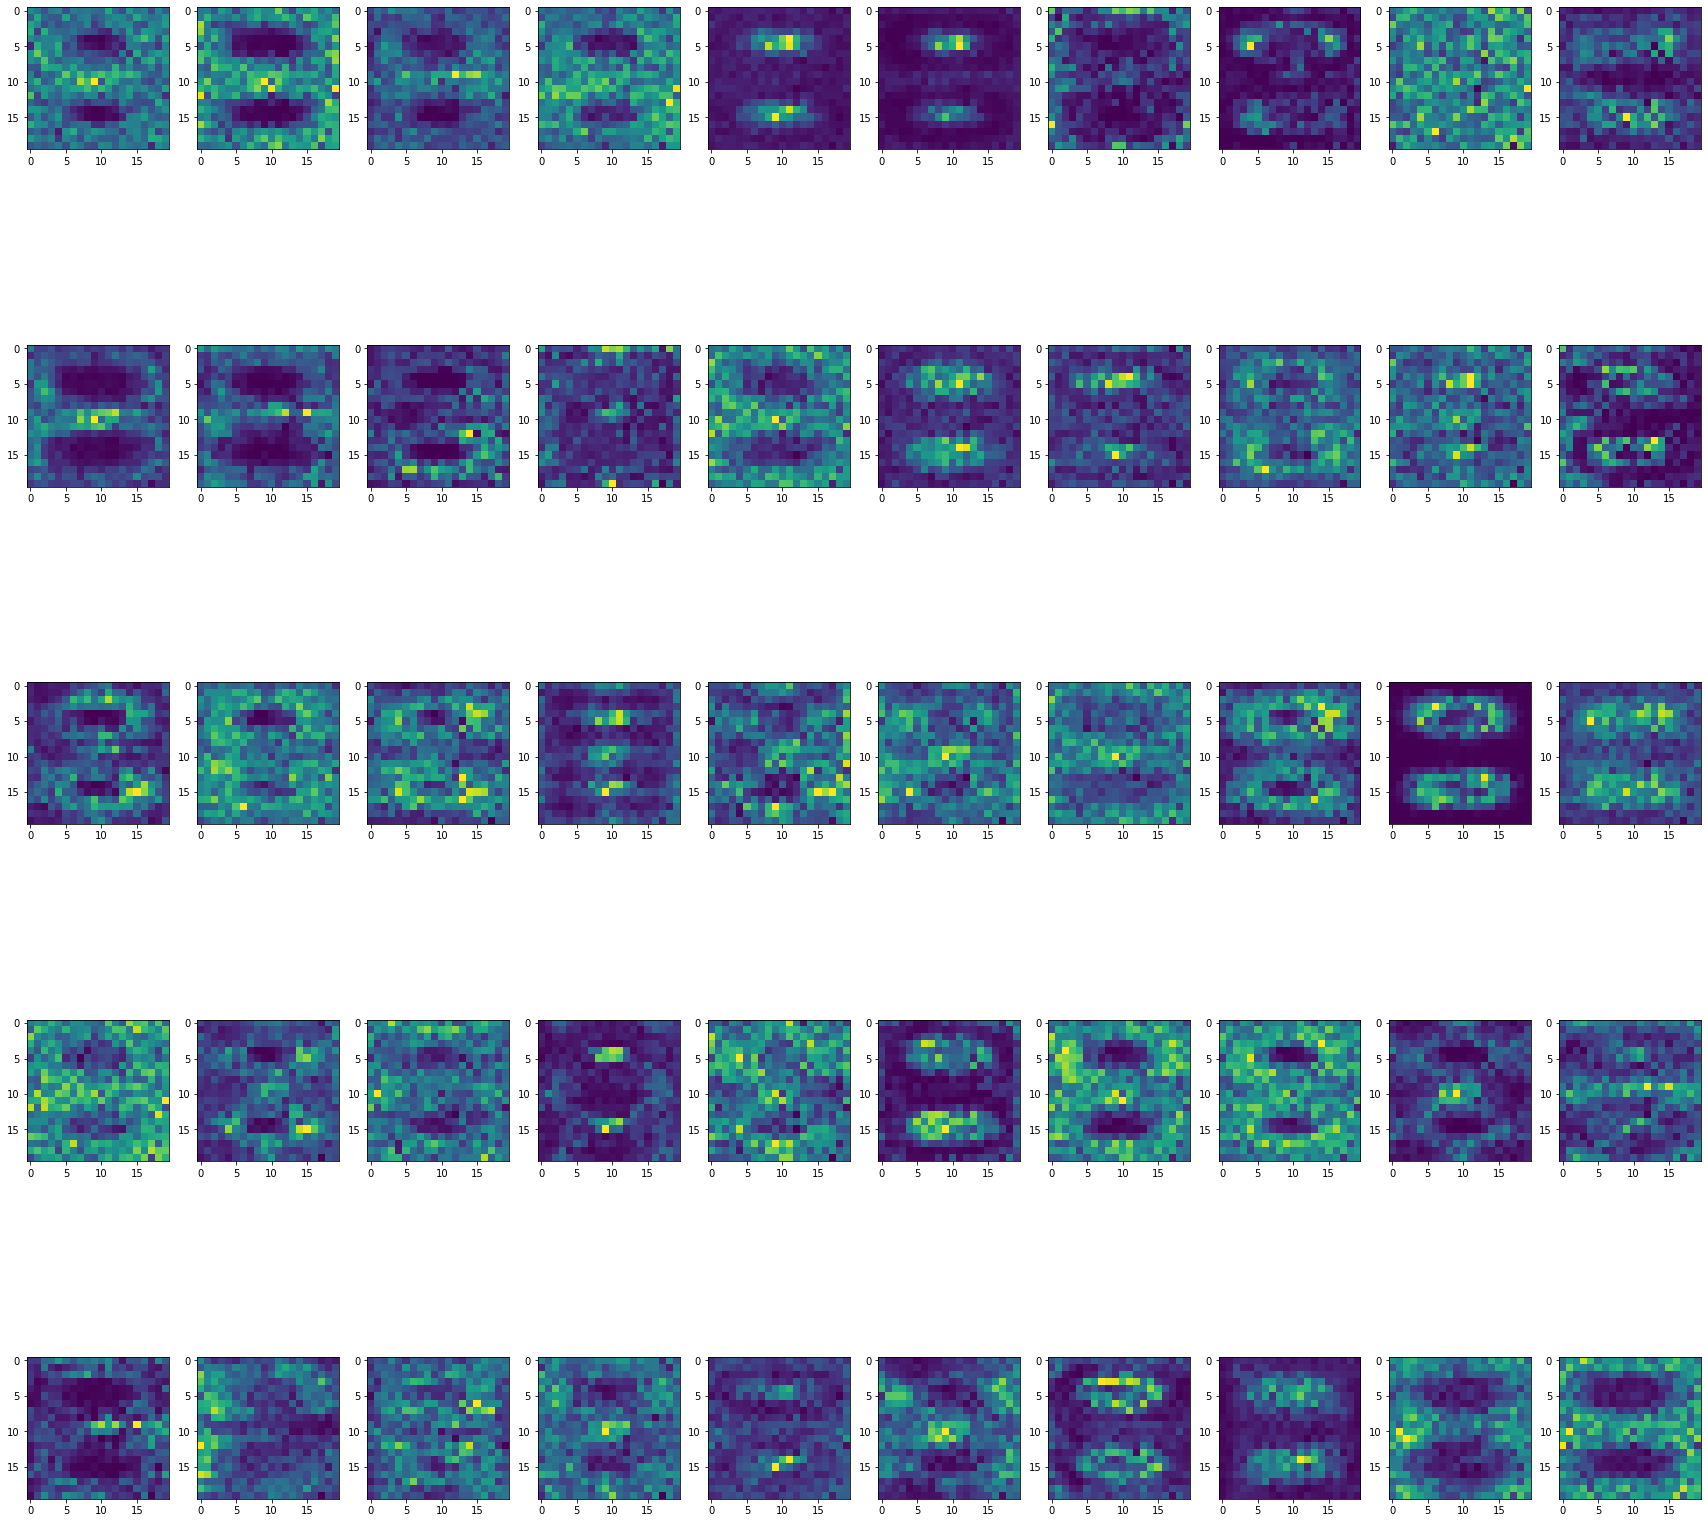

In [ ]:
plt.close('all')
_, axes = plt.subplots(5, 10, figsize=(30, 30))
for x in range(5):
    for y in range(10):
        axes[x][y].imshow(np.mean(activations_heatmaps[(x * 10) + y, 0], axis=2))